In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!pip install timm segmentation_models_pytorch rasterio
!apt install -y zip
# !pip install https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=171a00d410b742cb4800f20438f5754161b03a0ecaa6abd7d0da9c671b7f47d1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import rasterio
import matplotlib.pyplot as plt
import os
import cv2
import tifffile
from tqdm import tqdm
# import torch_xla
# import torch_xla.core.xla_model as xm

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("CUDA is available")
else:
  device = torch.device('cpu')
  print('CUDA is not available')

CUDA is not available


In [ ]:
device = xm.xla_device()

In [ ]:
PATH_SRC = f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/src'
PATH_OUTPUT = f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/submit'
PATHS_VAL = glob.glob(f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/evaluation_true_color/evaluation_true_color_*.tif')
PATHS_VAL_MASK = glob.glob(f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/sample/evaluation_mask_*.tif')
PATHS_TRAIN = glob.glob(f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/train_true_color/train_true_color_*.tif')
PATHS_TRAIN_MASK = glob.glob(f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/train_mask/train_mask_*.tif')

## Model

In [ ]:
import yaml
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base.initialization import initialize_decoder
from segmentation_models_pytorch.base import modules as md

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        dropout=0,
    ):
        super().__init__()


        conv_in_channels = in_channels + skip_channels


        # Convolve input embedding and upscaled embedding
        self.conv1 = md.Conv2dReLU(
            conv_in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )


        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )


        self.dropout_skip = nn.Dropout(p=dropout)


    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            skip = self.dropout_skip(skip)
            x = torch.cat([x, skip], dim=1)


        x = self.conv1(x)
        x = self.conv2(x)


        return x


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        use_batchnorm=True,
        dropout=0,
    ):
        super().__init__()


        encoder_channels = encoder_channels[::-1]


        # Computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels


        self.center = nn.Identity()


        # Combine decoder keyword arguments
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, use_batchnorm=use_batchnorm, dropout=dropout)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)


    def forward(self, features):
        features = features[::-1]  # reverse channels to start from head of encoder


        head = features[0]
        skips = features[1:]


        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)


        return x

in_chans = 3


cfg = yaml.safe_load(f"""
model:
  encoder: maxvit_tiny_tf_512.in1k  # I also use resnest26d
  pretrained: True    # Use True! False due to internet connection
  decoder_channels: [256, 128, 64, 32, 16]
  dropout: 0.0
  in_chans: {in_chans}
""")


def _check_reduction(reduction_factors):
    """
    Assume spatial dimensions of the features decrease by factors of two.
    For example, convnext start with stride=4 cannot be used in my code.
    """
    r_prev = 1
    for r in reduction_factors:
        if r / r_prev != 2:
            raise AssertionError('Reduction assumed to increase by 2: {}'.format(reduction_factors))
        r_prev = r


class Model(nn.Module):
    # The main U-Net model
    # See also TimmUniversalEncoder in Segmentation Models PyTorch
    def __init__(self, cfg, pretrained=True, tta=None):
        super().__init__()
        name = cfg['model']['encoder']
        dropout = cfg['model']['dropout']
        pretrained = pretrained and cfg['model']['pretrained']


        self.encoder = timm.create_model(name,
                                         features_only=True,
                                         pretrained=pretrained,
                                         in_chans=cfg['model']['in_chans'],)
        encoder_channels = self.encoder.feature_info.channels()


        _check_reduction(self.encoder.feature_info.reduction())


        decoder_channels = cfg['model']['decoder_channels']  # (256, 128, 64, 32, 16)
        print('Encoder channels:', name, encoder_channels)
        print('Decoder channels:', decoder_channels)


        assert len(encoder_channels) == len(decoder_channels)


        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            dropout=dropout,
        )


        self.segmentation_head = smp.base.SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=1, activation=None, kernel_size=3,
        )


        initialize_decoder(self.decoder)


    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(features)
        y_pred = self.segmentation_head(decoder_output)


        return y_pred

model = Model(cfg=cfg)

Encoder channels: maxvit_tiny_tf_512.in1k [64, 64, 128, 256, 512]
Decoder channels: [256, 128, 64, 32, 16]


### AE
We implement an autoencoder for cloud detection in PyTorch based on the CloudGAN model (https://github.com/JerrySchonenberg/CloudGAN/)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self,
                 input_res=512,
                 activation=F.relu,
                 activation_out=torch.sigmoid,
                 seed=42):
        super(AutoEncoder, self).__init__()

        torch.manual_seed(seed)  # Setting the random seed for reproducibility

        # Encoder definition
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder definition
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def to_hardmask(self, x):
        return torch.round(x)

# Creating an instance of the AutoEncoder
model = AutoEncoder()
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


## Training
We train the model of the google winners on our specific data. This leads to a oversampling but should get us a much higher accuracy on our data.

In [ ]:
df_val = pd.DataFrame({
    'true_color': PATHS_VAL,
    'mask': PATHS_VAL_MASK
})

df_train = pd.DataFrame({
    'true_color': PATHS_TRAIN,
    'mask': PATHS_TRAIN_MASK
})

### DataLoop

`DataTransform` includes the transformations

`CloudInferenceDataset` is a custom Dataset with get-Function

In [ ]:
class DataTransform():
    def __init__(self):
        self.data_transform = {
            "train": A.Compose(
                [
                  A.HorizontalFlip(p=0.25),
                  A.VerticalFlip(p=0.25),
                  A.Transpose(p=0.5),
                  A.Resize(512, 512, interpolation=1, p=1),
                  ToTensorV2()
                ]
            ),
            "val": A.Compose(
                [
                  A.Resize(512, 512, interpolation=1, p=1),
                  ToTensorV2(),
                ]
            )
        }

    def __call__(self, phase, img, mask):
        return self.data_transform[phase](image=img, mask=mask)

class CloudInferenceDataset(Dataset):
    def __init__(self, df, phase, transform,):
        self.df = df
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        row = self.df.iloc[index]
        true_color_PATH = row['true_color']
        mask_PATH = row['mask']
        img = tifffile.imread(true_color_PATH)
        img = img.astype(np.float32)
        mask = tifffile.imread(mask_PATH)
        mask = mask.astype(np.float32)

        img_and_mask = self.transform(self.phase, img, mask)
        img = img_and_mask["image"]
        mask = img_and_mask["mask"]

        return img, mask

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW([dict(params=model.parameters(), lr=1e-4),])

In [ ]:
BATCH_SIZE = 12

train_dataset = CloudInferenceDataset(df_train, phase="train", transform=DataTransform())
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


val_dataset = CloudInferenceDataset(df_val, phase="val", transform=DataTransform())
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

### Training Loop

In [ ]:
import gc  # Garbage Collector
gc.collect()  # Garbage Collector explizit aufrufen
torch.cuda.empty_cache()

In [ ]:
EPOCHS = 20
best_score = 1E5

train_loss = []
val_loss = []

#model = torch.load(f'{PATH_SRC}/best_model.pth')
model = model.to(device)

for epoch in range(0, EPOCHS):
  loss_epoch = []

  for phase in ['train', 'val']:
      print(f'\nEpoch: {epoch} Phase {phase}')
      for (img, mask) in tqdm(dataloaders_dict[phase],
                              total=len(dataloaders_dict[phase]),
                              leave=True,
                              dynamic_ncols=True):
        img, mask = img.to(device), mask.to(device)

        # training
        if phase == 'train':
          model.train()
          optimizer.zero_grad()
          output = model(img)
          loss = loss_fn(output.squeeze(dim=1), mask.squeeze(dim=1))
          loss.backward()
          optimizer.step()
          #xm.optimizer_step(optimizer)
          loss = loss.cpu().detach().numpy()

        # validation
        else:
          with torch.no_grad():
            model.eval()
            output = model(img)
            loss = loss_fn(output.squeeze(dim=1), mask.squeeze(dim=1))
            loss = loss.cpu().numpy()

        loss_epoch.append(loss)

      if phase == 'train':
        train_loss.append(np.array(loss_epoch).mean())
      else:
        loss_mean = np.array(loss_epoch).mean()
        val_loss.append(loss_mean)

        if best_score > loss_mean:
            best_score = loss_mean

            torch.save(model, os.path.join(PATH_SRC, f'ae_model.pth'))

print(best_score)


Epoch: 0 Phase train


100%|██████████| 84/84 [08:00<00:00,  5.72s/it]



Epoch: 0 Phase val


100%|██████████| 84/84 [08:21<00:00,  5.97s/it]



Epoch: 1 Phase train


100%|██████████| 84/84 [01:15<00:00,  1.11it/s]



Epoch: 1 Phase val


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]



Epoch: 2 Phase train


100%|██████████| 84/84 [01:16<00:00,  1.10it/s]



Epoch: 2 Phase val


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]



Epoch: 3 Phase train


100%|██████████| 84/84 [01:16<00:00,  1.10it/s]



Epoch: 3 Phase val


100%|██████████| 84/84 [00:53<00:00,  1.58it/s]



Epoch: 4 Phase train


100%|██████████| 84/84 [01:15<00:00,  1.11it/s]



Epoch: 4 Phase val


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]



Epoch: 5 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.12it/s]



Epoch: 5 Phase val


100%|██████████| 84/84 [00:53<00:00,  1.58it/s]



Epoch: 6 Phase train


100%|██████████| 84/84 [01:15<00:00,  1.11it/s]



Epoch: 6 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.59it/s]



Epoch: 7 Phase train


100%|██████████| 84/84 [01:13<00:00,  1.14it/s]



Epoch: 7 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.60it/s]



Epoch: 8 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.12it/s]



Epoch: 8 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.61it/s]



Epoch: 9 Phase train


100%|██████████| 84/84 [01:15<00:00,  1.12it/s]



Epoch: 9 Phase val


100%|██████████| 84/84 [00:51<00:00,  1.62it/s]



Epoch: 10 Phase train


100%|██████████| 84/84 [01:13<00:00,  1.14it/s]



Epoch: 10 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.59it/s]



Epoch: 11 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.13it/s]



Epoch: 11 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.59it/s]



Epoch: 12 Phase train


100%|██████████| 84/84 [01:13<00:00,  1.14it/s]



Epoch: 12 Phase val


100%|██████████| 84/84 [00:50<00:00,  1.66it/s]



Epoch: 13 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.13it/s]



Epoch: 13 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.61it/s]



Epoch: 14 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.13it/s]



Epoch: 14 Phase val


100%|██████████| 84/84 [00:50<00:00,  1.67it/s]



Epoch: 15 Phase train


100%|██████████| 84/84 [01:13<00:00,  1.14it/s]



Epoch: 15 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.61it/s]



Epoch: 16 Phase train


100%|██████████| 84/84 [01:13<00:00,  1.15it/s]



Epoch: 16 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.60it/s]



Epoch: 17 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.13it/s]



Epoch: 17 Phase val


100%|██████████| 84/84 [00:52<00:00,  1.60it/s]



Epoch: 18 Phase train


100%|██████████| 84/84 [01:13<00:00,  1.14it/s]



Epoch: 18 Phase val


100%|██████████| 84/84 [00:51<00:00,  1.63it/s]



Epoch: 19 Phase train


100%|██████████| 84/84 [01:14<00:00,  1.13it/s]



Epoch: 19 Phase val


100%|██████████| 84/84 [00:51<00:00,  1.62it/s]

0.6931472


## Submit

  0%|          | 0/84 [00:00<?, ?it/s]

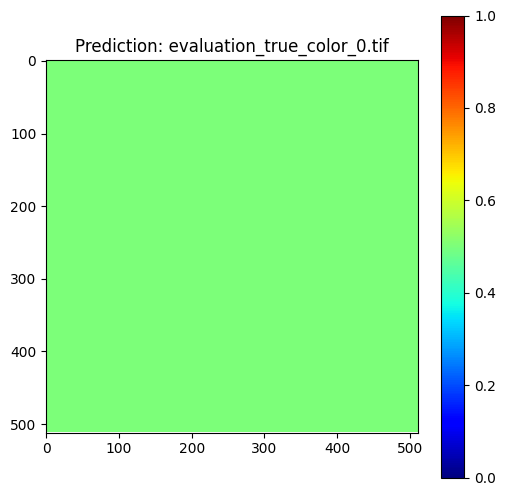

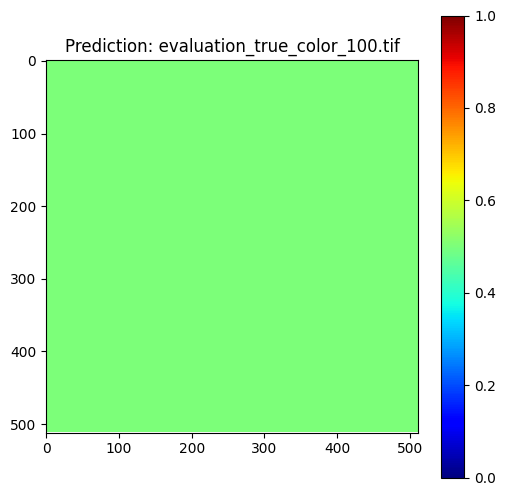

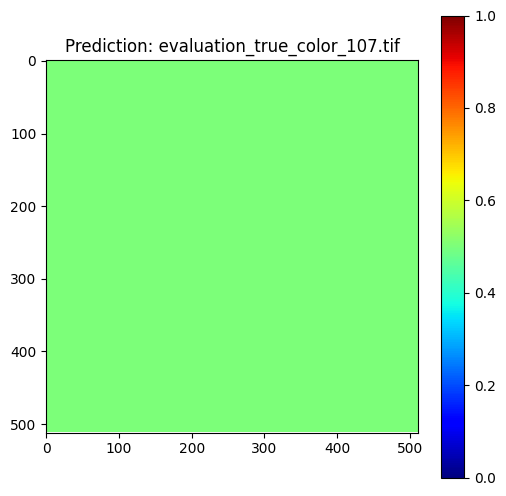

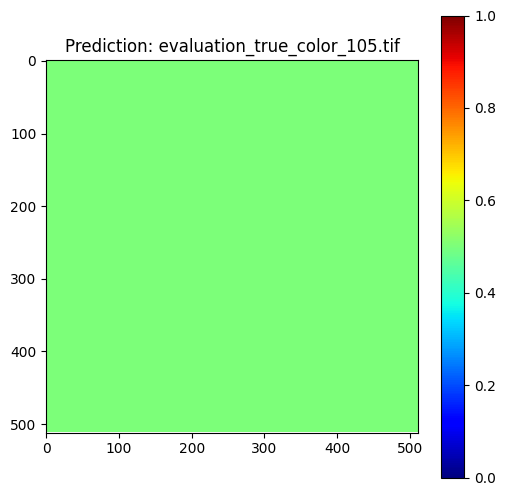

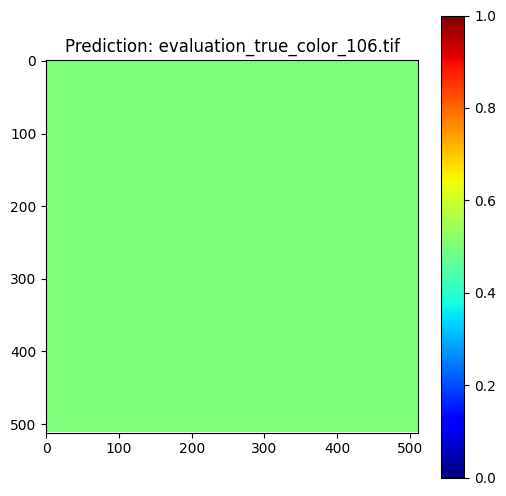

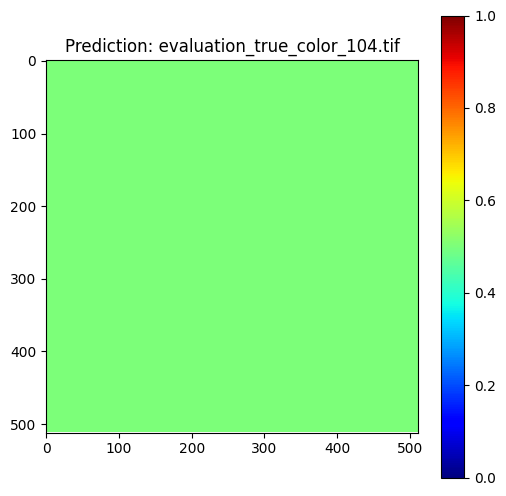

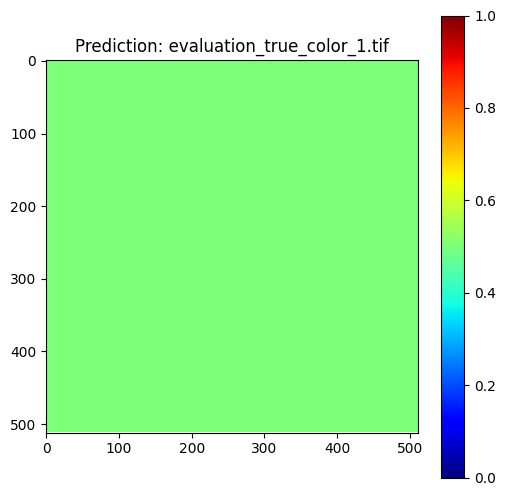

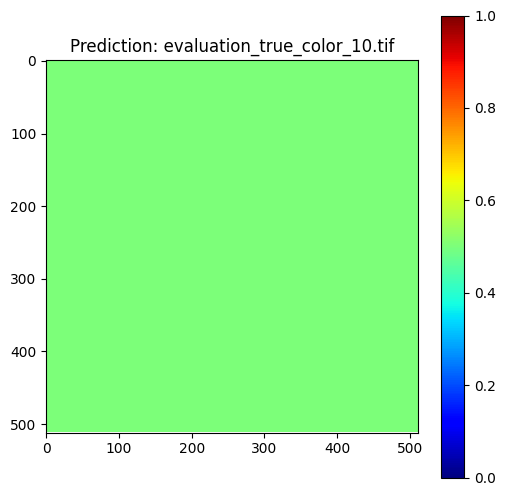

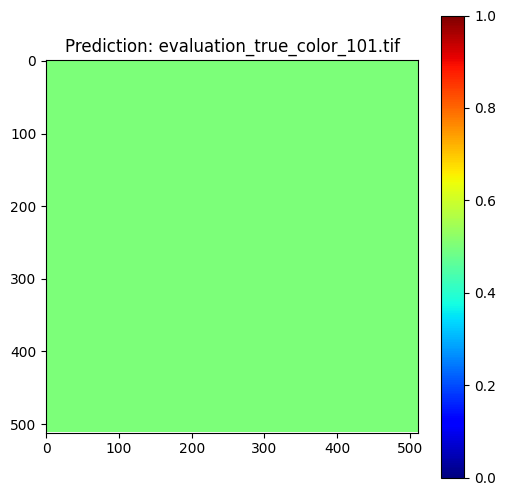

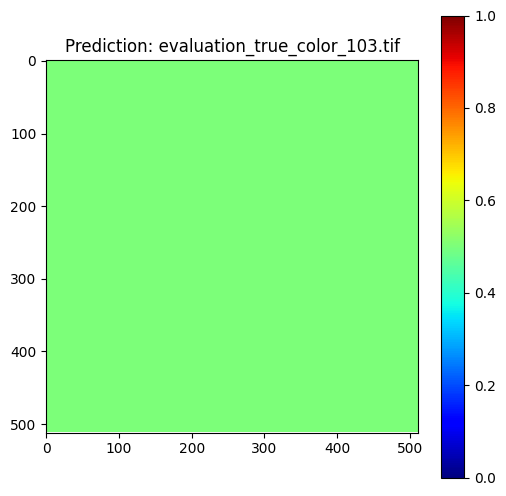

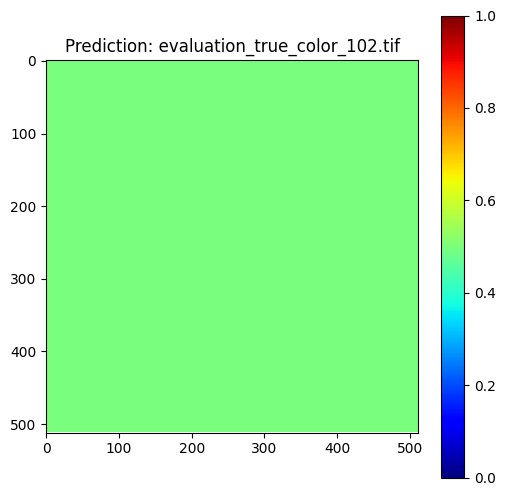

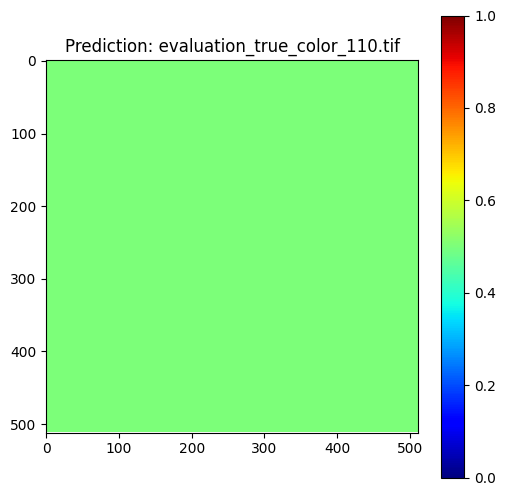

100%|██████████| 84/84 [12:47<00:00,  9.14s/it]


In [ ]:
PATH_MODEL = f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/src/ae_model.pth'

BATCH_SIZE = 12

model = torch.load(PATH_MODEL)
model = model.to(device)
model.eval()
for i, (img, mask) in tqdm(enumerate(dataloaders_dict['val']), total=len(dataloaders_dict['val'])):
    with torch.no_grad():
      img = img.to(device)
      output = model(img)
      output = output.squeeze(dim=1)
      preds = torch.sigmoid(output)

      for batch_i, pred in enumerate(preds.cpu().numpy()):
          plt.figure(figsize=(6, 6))

          PATH = df_val['true_color'].iloc[i*BATCH_SIZE + batch_i]
          fname = os.path.basename(PATH)
          fname_wo_ext = fname.split('.')[0]

          plt.title(f'Prediction: {fname}')
          plt.imshow(pred, cmap='jet', vmin=0, vmax=1)
          plt.colorbar()
          plt.savefig(f"{PATH_OUTPUT}/predict_{fname_wo_ext}.png")

          if i == 0:
              plt.show();

          plt.clf()
          plt.close()

          # post process
          pred_sub = cv2.resize(pred, (1000, 1000), interpolation=0)
          pred_sub = (pred_sub > 0.5).astype(np.uint8)

          idx = fname.split("_")[-1]

          tifffile.imwrite(f"{PATH_OUTPUT}/evaluation_mask_{idx}", pred_sub)

### Look at Mask

[0]


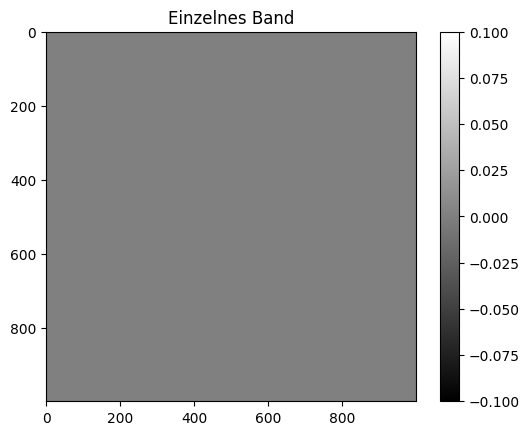

In [11]:
with rasterio.open(f"/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/sample/evaluation_mask_5.tif") as src:
  print(np.unique(img))
  img = src.read(1)

plt.imshow(img, cmap='gray')
plt.colorbar()
plt.title("Einzelnes Band")
plt.show()

In [ ]:
import os
PATH_ZIP = f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/finished_submits/submit_trained.zip'
PATH_SUBMITS = f'/content/drive/MyDrive/Projekte/Solafune/Cloud_satelite/submit/evaluation_mask_*.tif'

os.system(f'zip -j {PATH_ZIP} {PATH_SUBMITS}')

0